# Pipeline analysis of the Face Perception Dataset


### Load Libraries 

In [1]:
import os 
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
import pathlib
from mne.preprocessing import compute_current_source_density
from mne.io import read_raw_fif, concatenate_raws
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore

In [ ]:
%matplotlib qt

In [2]:
matplotlib.use('Qt5Agg')

### Load the data

In [3]:
# define paths
data_dir = '/Users/christinadelta/datasets/multimodal_bids'
derivatives_dir = os.path.join(data_dir, 'derivatives')
stimuli_dir = os.path.join(data_dir, 'stimuli')
emptyroom_dir = os.path.join(data_dir, 'sub-emptyroom')
task = 'facerecognition'
output_dir = os.path.join(data_dir, 'output')

In [4]:
# choose number of runs per subject and number of subjects to analyse 
runs = 3 # 6 runs for each subject
raws = []
subject = 1

In [5]:
for sub in range(subject):
    this_sub = 'sub-{0:02d}'.format(sub+1)
    for run in range(runs):
        this_run = '{0:02d}'.format(run+1)
        this_eeg = os.path.join(data_dir, this_sub, 'ses-meg', 'meg',
                                f'{this_sub}_ses-meg_task-{task}_run-{this_run}_meg.fif')
        
        this_raw = read_raw_fif(this_eeg, preload=True)
        raws.append(this_raw)

Opening raw data file /Users/christinadelta/datasets/multimodal_bids/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_meg.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 248600 ... 788699 =    226.000 ...   716.999 secs
Ready.
Reading 0 ... 540099  =      0.000 ...   490.999 secs...
Opening raw data file /Users/christinadelta/datasets/multimodal_bids/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-02_meg.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (

In [6]:
# merge the runs 
# concatinate the 6 raw files
raw = concatenate_raws(raws)
raw

<Raw | sub-01_ses-meg_task-facerecognition_run-01_meg.fif, 395 x 1642300 (1493.0 s), ~4.84 GB, data loaded>

In [7]:
raw.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 GRAD, 102 MAG, 74 EEG, 3 STIM, 12 MISC
 custom_ref_applied: False
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 356.4 Hz
 meas_date: 2009-04-09 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 395
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: mag_ssp_upright.fif : PCA-mags-v1: off, mag_ssp_upright.fif : ...
 sfreq: 1100.0 Hz
 subject_info: 6 items (dict)
>

### Choose the data
This is a MEG recording that also contains EEG data (74 channels). We will only use the EEG data, so get rid of the MEG channels.
We will create a **eeg_raw** class/object for our raw data. To keep only the eeg data we will use the ```mne.pick_types()``` function

In [8]:
eeg_raw = raw.pick_types(eeg=True, meg=False, stim=True, eog=True)

Removing projector <Projection | mag_ssp_upright.fif : PCA-mags-v1, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-mags-v2, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-mags-v3, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-mags-v4, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-mags-v5, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-grad-v1, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-grad-v2, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-grad-v3, active : False, n_channels : 306>


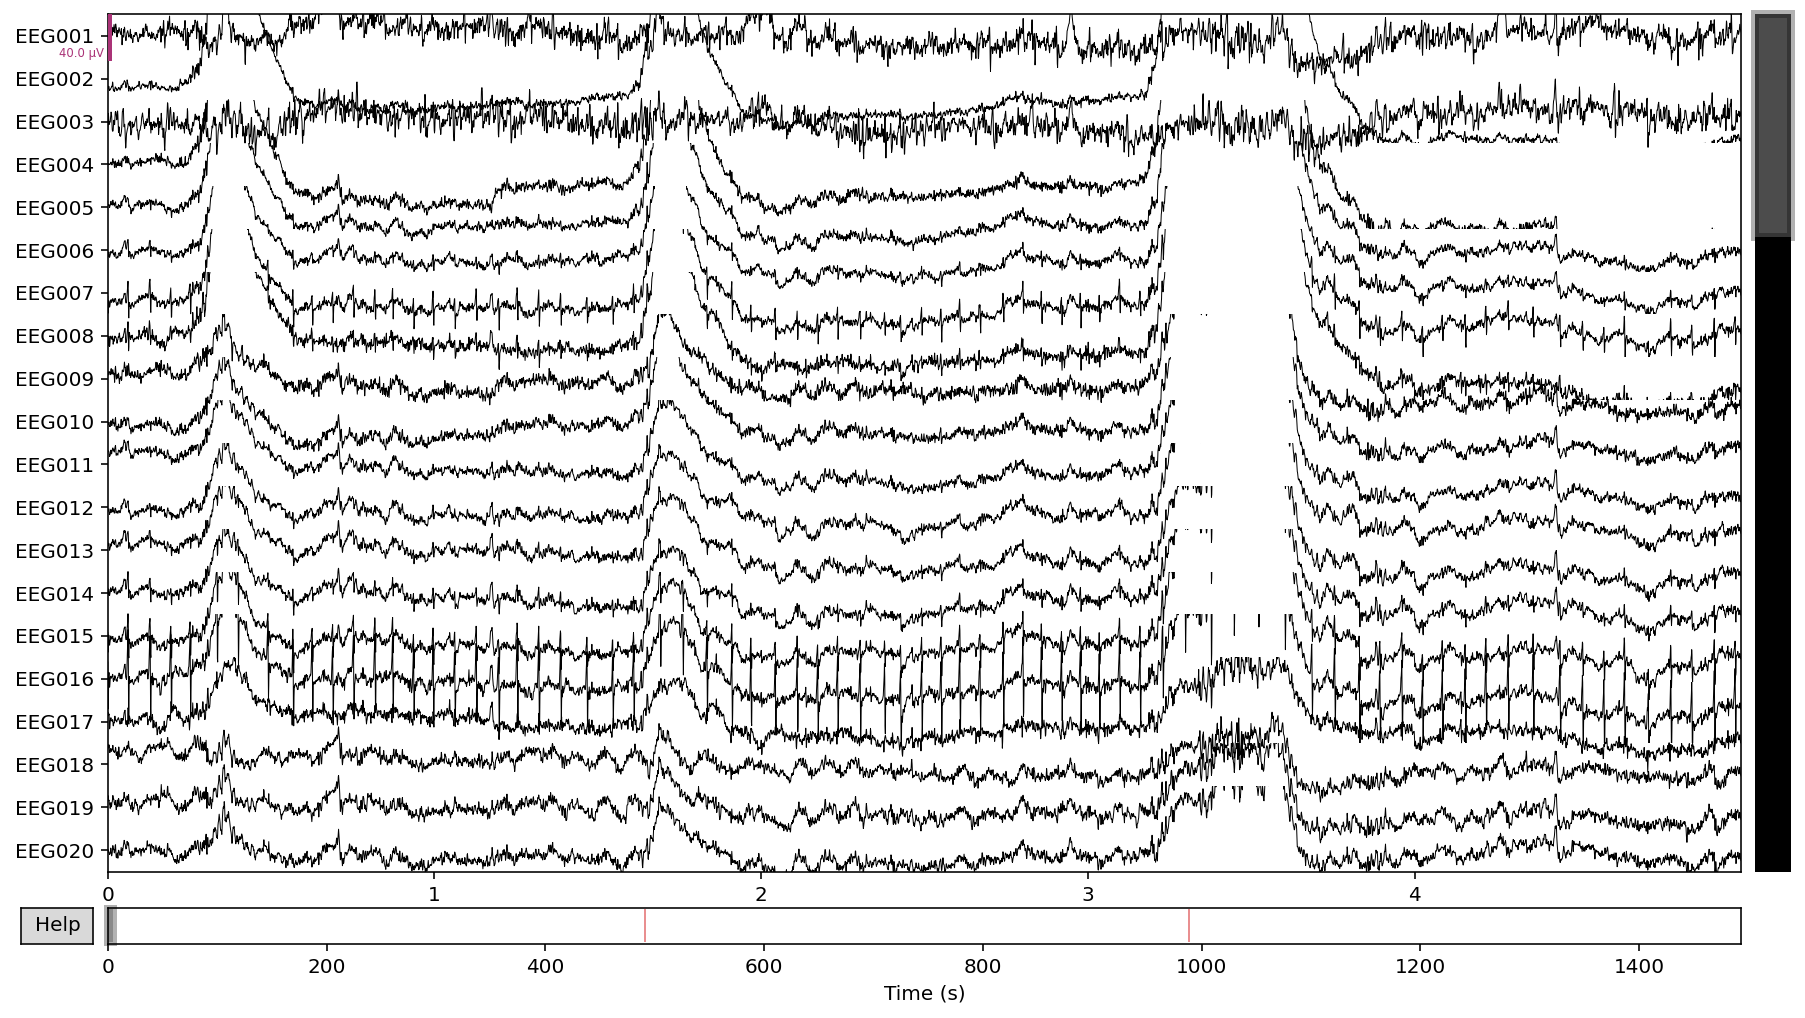

In [9]:
eeg_raw.plot(duration=5)

### Plot power spectrum

In [ ]:
eeg_raw.plot_psd(fmin=1, fmax=20, n_fft=2**10, spatial_colors=True)

### Filter the raw eeg data

In [ ]:
eeg_filtered = eeg_raw.copy().filter(l_freq=0.1, h_freq=40)

### Run ICA

In [ ]:
ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)

In [ ]:
ica.fit(eeg_filtered)

In [ ]:
ica.plot_components()

In [ ]:
# blinks
ica.plot_overlay(eeg_filtered, exclude=[0], picks='eeg')

In [ ]:
# exclude bad components
ica.exclude = [0,1]  # indices chosen based on various plots above

### Make copy of the original raw, apply ICA and visualise both

In [ ]:
orig_raw = eeg_raw.copy()
ica.apply(eeg_filtered)

### Plot the raw and the cleaned data side by side and inspect

In [ ]:
orig_raw.plot(start=0, duration=5, block=False, title= 'before ICA')
eeg_filtered.plot(start=0, duration=5, block=True, title='after ICA')

### Add events

In [ ]:
events = mne.find_events(eeg_raw)
print(events[:5])

In [ ]:
# create events_id dictionary 
event_id = {
    'famous_in': 5,
    'famous_imm': 6, 
    'famous_del': 7,
    'unfam_in': 13,
    'unfam_imm': 14,
    'unfam_del': 15,
    'scram_in': 17,
    'scram_imm': 18,
    'scram_del': 19
}

In [ ]:
# visualise events
events_fig = mne.viz.plot_events(events, event_id=event_id,  sfreq=eeg_raw.info['sfreq'], 
                          first_samp=eeg_raw.first_samp)

In [ ]:
eeg_filtered.plot(duration=10, events=events, event_id=event_id)

### Epoch the data

In [ ]:
tmin = -0.5
tmax = 1.2
baseline = (-0.20, 0) 
reject_criteria = dict(eeg=150e-6)

In [ ]:
epochs = mne.Epochs(eeg_filtered, 
                    events=events, 
                    event_id=event_id, 
                    tmin=tmin, 
                    tmax=tmax,
                    baseline=baseline,
                    reject=reject_criteria, 
                    preload=True)

In [ ]:
epochs.plot(events=events, event_id=event_id)

### Select epochs of interest

In [ ]:
famous_in = epochs['famous_in']
famous_imm = epochs['famous_imm']
famous_del = epochs['famous_del']
unfam_in = epochs['unfam_in']
unfam_imm = epochs['unfam_imm']
unfam_del = epochs['unfam_del']
scram_in = epochs['scram_in']
scram_imm = epochs['scram_imm']
scram_del = epochs['scram_del']

### Combine epochs 
make three epoch objects, for famous, unfamiliar and scrambled stimuli

In [ ]:
famous_epochs = epochs['famous_in', 'famous_imm', 'famous_del']
unfamiliar_epochs = epochs['unfam_in', 'unfam_imm', 'unfam_del']
scrambled_epochs = epochs['scram_in', 'scram_imm', 'scram_del']

In [ ]:
unfamiliar_epochs

#### Calculate empirical evoked difference
We first calculate evoked responses of famous and unfamiliar (initial, immediate and delayed) stimuli, and then we will calculate the difference of the two.

In [ ]:
# calculate the difference between epochs of famous and unfamiliar faces
evoked_diff = mne.combine_evoked(
    [famous_epochs['famous_in', 'famous_imm', 'famous_del'].average(),
     unfamiliar_epochs['unfam_in', 'unfam_imm', 'unfam_del'].average()],
    weights=[1, -1]  # Subtraction
)

evoked_diff.plot(gfp=True)
mne.viz.plot_compare_evokeds(
    [famous_epochs['famous_in', 'famous_imm', 'famous_del'].average(),
     unfamiliar_epochs['unfam_in', 'unfam_imm', 'unfam_del'].average(),
     evoked_diff]
)

#### Equalise the number of trials for each condition

In [ ]:
epochs.equalize_event_counts(['famous_in', 
                              'famous_imm', 
                              'famous_del', 
                              'unfam_in',
                              'unfam_imm', 
                              'unfam_del', 
                              'scram_in', 
                              'scram_imm', 
                              'scram_del'])

## Run Decoding Analysis
### Way 1: Decoding using sklearn 
#### Create a classifier

A classifier takes as input a matrix X and returns a vector y (consisting of 0 and 1). Here X will be **the data at one time point** on all channels (hence the term multivariate). We want to train our model to discriminate between the ```famous_initial``` and the ```scrambled_initial``` face trials.

We work with all sensors jointly and try to find a discriminative pattern between the two conditions to predict the experimental condition of individual trials.

Let's first create the response vector, y. I will add the epochs of interest in one epoch object for now. We will call this ```epochs_y``` 

In [ ]:
epochs_y = epochs['famous_in', 'scram_in']
epochs_y

In [ ]:
# Create an vector with length = no. of trials.
y = np.empty(len(epochs_y.events), dtype=int)   

# Which trials are famous initial, which are scrambled initial?
idx_famous = epochs_y.events[:,2] == epochs_y.event_id['famous_in']
idx_scrambled = epochs_y.events[:,2] == epochs_y.event_id['scram_in']
idx_scrambled
# count the number of true booleans in the "famous" array
print(np.count_nonzero(idx_famous))
print(np.count_nonzero(idx_scrambled))

In [ ]:
# encode famous as 0 and scrambled as 1
y[idx_famous] = 0
y[idx_scrambled] = 1
print(y) # visualise

Now, let's create the input matrix, X.
We focus only on the EEG channels here, so we use ```pick_types(meg=False)``` and  ```(eeg=True)```. For magnetometer channels, we would need to pass meg='mag'. We create a copy of the epochs because pick_types() operates in-place, but we would like to keep the original epochs object untouched.

In [ ]:
epoched_data = epochs_y.copy().pick_types(meg=False, eeg=True)
epoched_data 

In [ ]:
# Retrieve the data as a NumPy array.
# The array has the shape: (n_trials, n_channels, n_timepoints)
data = epoched_data.get_data()
print(data.shape)
data

We need to reshape the array such that for each trial, we have a vector ```[channel_1_time_1, channel_1_time_2, ..., channel_m_time_n]```, i.e., we aim to reshape X to the dimension (n_trials, n_channels * n_timepoints).

In [ ]:
n_trials = data.shape[0]
X = data.reshape(n_trials, -1)
print(X.shape)

## Make a clasifier using sklearn 

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
# The classifier pipeline: it is extremely important to scale the data
# before running the actual classifier (logistic regression in our case).
clf = make_pipeline(StandardScaler(),
                    LogisticRegression())

clf

In [ ]:
# Run cross-validation.
# CV without shuffling – "block cross-validation" – is what we want here
# (scikit-learn doesn't shuffle by default, which is good for us).
n_splits = 5
scoring = 'accuracy' # we could also use 'accuracy', but 'roc_auc' seems to be more robust in many cases
cv = StratifiedKFold(n_splits=n_splits)
scores = cross_val_score(clf, X=X, y=y, cv=cv, scoring=scoring)
scores

In [ ]:
# Mean and standard deviation of ROC AUC across cross-validation runs.
acc_mean = round(np.mean(scores), 3)
acc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ACCURACY = {roc_auc_mean:.3f} (SD = {acc_std:.3f})')

### Visualise the CV results

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(scores,
           showmeans=True, # Green triangle marks the mean.
           whis=(0, 100),  # Whiskers span the entire range of the data.
           labels=['famous vs scrambled'])
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Scores')